# Computer Vision Model Development of Age Determination for The supermarket chain Good Seed

# Project Goals

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. We are asked to conduct that evaluation, with below conditions:

1. The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol.
2. Computer vision methods can be used to determine age of a person from a photo.
3. The task then is to build and evaluate a model for verifying people's age.
4. To start working on the task, we are given a set of photographs of people with their ages indicated.

# Project Instructions

1. Perform exploratory data analysis to get an overall impression of the dataset.
2. Train and evaluate the model (it needs to be done on the GPU platform).
3. Combine the code, output and findings in the final Jupyter notebook.
4. Make conclusions of the model evaluation, add them to the notebook.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Review-Iteration" data-toc-modified-id="Review-Iteration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Review Iteration</a></span><ul class="toc-item"><li><span><a href="#Review-Iteration-1" data-toc-modified-id="Review-Iteration-1-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Review Iteration 1</a></span></li></ul></li><li><span><a href="#Initialization" data-toc-modified-id="Initialization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Findings" data-toc-modified-id="Findings-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Findings</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelling</a></span></li><li><span><a href="#Prepare-the-Script-to-Run-on-the-GPU-Platform" data-toc-modified-id="Prepare-the-Script-to-Run-on-the-GPU-Platform-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Prepare the Script to Run on the GPU Platform</a></span><ul class="toc-item"><li><span><a href="#Output" data-toc-modified-id="Output-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Output</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

## Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import inspect

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
num_classes = labels['real_age'].nunique()

train_datagen = ImageDataGenerator(horizontal_flip=True, rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


## EDA

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


There are total 7591 photos with 2 columns (file_name & real_age).

In [5]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

There is no missing values.

In [6]:
labels.duplicated().sum()

0

There is no duplicated values.

In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [8]:
# Grouped the age with interval of 5

age_group = pd.cut(labels['real_age'], np.arange(0, 101, 5), right=False).value_counts().sort_index()
age_group

[0, 5)        363
[5, 10)       300
[10, 15)      356
[15, 20)      857
[20, 25)      924
[25, 30)     1151
[30, 35)      920
[35, 40)      644
[40, 45)      545
[45, 50)      395
[50, 55)      391
[55, 60)      224
[60, 65)      174
[65, 70)      105
[70, 75)       89
[75, 80)       41
[80, 85)       50
[85, 90)       28
[90, 95)       28
[95, 100)       5
Name: real_age, dtype: int64

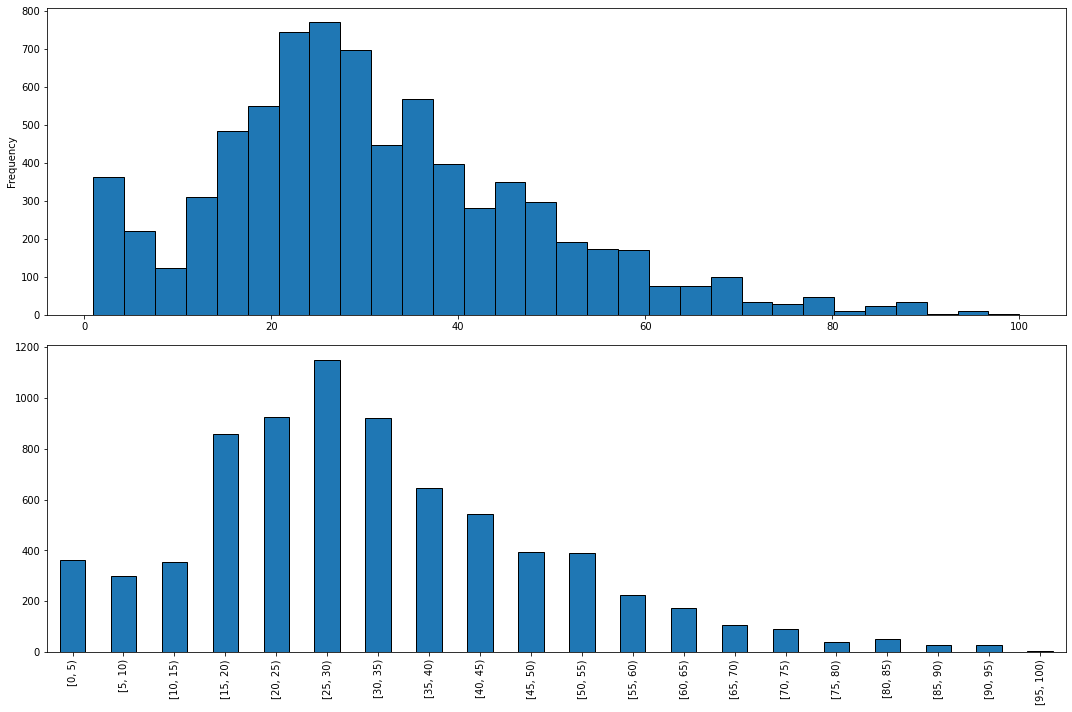

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

ax = axs[0]
labels['real_age'].plot(kind='hist', bins=30, edgecolor='black', ax=ax)

ax = axs[1]
age_group.plot(kind='bar', edgecolor='black', ax=ax)

fig.tight_layout()

From the above distribution, the real_age column is a feature with a value does not exceed 100, thus we can calculate its exact value to see its distribution.

The majority of the age group in the dataset is between age 15 to 45.

In [10]:
def create_gen_flow(min_age=0, max_age=100):

    datagen = ImageDataGenerator(rescale=1./255)

    gen_flow = datagen.flow_from_dataframe(
        dataframe=labels.query('real_age >= @min_age and real_age <= @max_age'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

    return gen_flow

In [11]:
# Print 10 photos for different ages

def show_batch(batch, predictions=None):

    rows = 2
    cols = 5
    fig, axs = plt.subplots(rows, cols, figsize=(10, 6))

    for i in range(10):

        row = i // cols
        col = i % cols
        ax = axs[row][col]
        ax.imshow(batch[0][i])
        real_age = batch[1][i]
        if predictions is None:
            title = f'age: {real_age}'
        else:
            title = f'age: {real_age}, pred: {round(predictions[i])}'
        ax.set_title(title, fontsize='medium')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    fig.tight_layout()

In [12]:
gen_flow_0_9 = create_gen_flow(min_age=0, max_age=9)
gen_flow_10_79 = create_gen_flow(min_age=10, max_age=79)
gen_flow_80_100 = create_gen_flow(min_age=80, max_age=100)

Found 663 validated image filenames.
Found 6816 validated image filenames.
Found 112 validated image filenames.


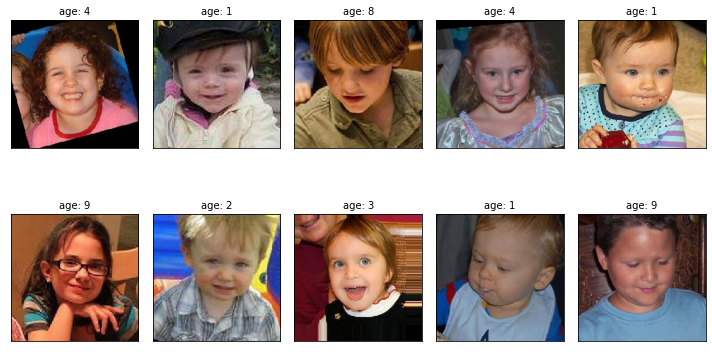

In [13]:
show_batch(next(gen_flow_0_9))

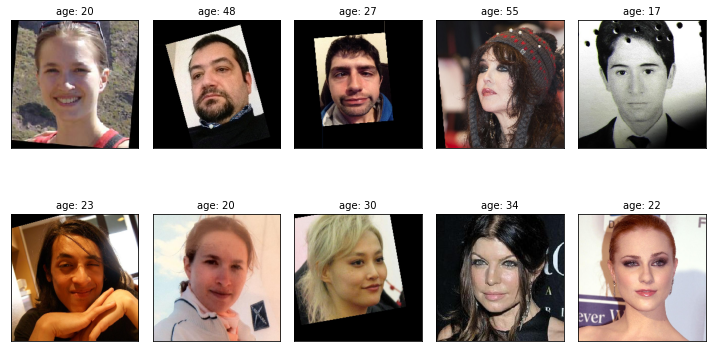

In [14]:
show_batch(next(gen_flow_10_79))

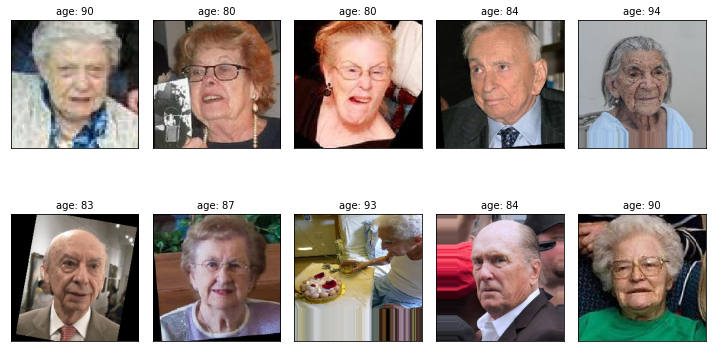

In [15]:
show_batch(next(gen_flow_80_100))

### Findings

1.  The dataset has a diverse age distribution, from 1 to 100 years old.
2.  There is class imbalance, as age 60 and above have fewer samples.
3. It's essential to preprocess the images appropriately and consider data augmentation to improve generalization. There are photos of different quality: old, black and white, and colour images. We only used horizontal flip (as the orientation of the face (left or right) should not affect the age prediction)in this project.
4. Model evaluation metrics should account for the age prediction task, considering potential imbalances in different age groups.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [16]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [17]:
def load_train(path):
    """
    It loads the train part of the dataset from the given path
    """
    train_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1/255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_gen_flow

In [18]:
def load_test(path):
    """
    It loads the validation/test part of the dataset from the given path
    """
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_gen_flow

In [19]:
def create_model(input_shape=(224, 224, 3), num_classes=1):
    """
    It defines the model
    """
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation='linear')) # Use linear activation for regression

    for layer in base_model.layers:
        layer.trainable = True

    optimizer = Adam(learning_rate=0.0001)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae']
    )

    return model

In [20]:

def train_model(model, train_data, test_data, batch_size=None, epochs=25,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    # Learning rate schedule
    def lr_schedule(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * np.exp(-0.1)

    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Model checkpointing
    model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[lr_scheduler, early_stopping, model_checkpoint],
        verbose=2
    )

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [21]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Train for 178 steps, validate for 60 steps
Epoch 1/25
2023-11-30 16:43:02.559173: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-30 16:43:02.790206: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 47s - loss: 222.3369 - mae: 10.6481 - val_loss: 742.1256 - val_mae: 22.2899
Epoch 2/25
178/178 - 40s - loss: 74.2744 - mae: 6.4980 - val_loss: 688.8844 - val_mae: 20.9803
Epoch 3/25
178/178 - 40s - loss: 48.8490 - mae: 5.3578 - val_loss: 257.9049 - val_mae: 11.7171
Epoch 4/25
178/178 - 40s - loss: 35.4723 - mae: 4.5567 - val_loss: 226.9281 - val_mae: 11.3062
Epoch 5/25
178/178 - 40s - loss: 28.8697 - mae: 4.0754 - val_loss: 109.2608 - val_mae: 7.9732
Epoch 6/25
178/178 - 39s - loss: 22.7762 - mae: 3.6351 - val_loss: 66.2304 - val_mae: 6.1746
Epoch 7/25
178/178 - 37s - loss: 17.9925 - mae: 3.2457 - val_loss: 72.3427 - val_mae: 6.2522
Epoch 8/25
178/178 - 40s - loss: 14.8437 - mae: 2.9573 - val_loss: 63.6577 - val_mae: 5.9908
Epoch 9/25
178/178 - 40s - loss: 12.4269 - mae: 2.6894 - val_loss: 61.2882 - val_mae: 5.9229
Epoch 10/25
178/178 - 37s - loss: 9.6172 - mae: 2.3625 - val_loss: 66.9817 - val_mae: 6.1156
Epoch 11/25
178/178 - 37s - loss: 8.3610 - mae: 2.1948 - val_loss: 62.7684 - val_mae: 5.8420
Epoch 12/25
178/178 - 40s - loss: 6.2050 - mae: 1.8883 - val_loss: 61.1804 - val_mae: 5.8616
Epoch 13/25
178/178 - 40s - loss: 4.7395 - mae: 1.6353 - val_loss: 58.9939 - val_mae: 5.8068
Epoch 14/25
178/178 - 40s - loss: 3.6625 - mae: 1.4131 - val_loss: 58.0877 - val_mae: 5.6932
Epoch 15/25
178/178 - 39s - loss: 2.6456 - mae: 1.2036 - val_loss: 57.6080 - val_mae: 5.7113
Epoch 16/25
178/178 - 37s - loss: 2.0837 - mae: 1.0597 - val_loss: 57.7338 - val_mae: 5.6958
Epoch 17/25
178/178 - 38s - loss: 1.4461 - mae: 0.8934 - val_loss: 57.7245 - val_mae: 5.6803
Epoch 18/25
178/178 - 37s - loss: 1.0490 - mae: 0.7663 - val_loss: 58.8555 - val_mae: 5.6711
Epoch 19/25
178/178 - 40s - loss: 0.7054 - mae: 0.6234 - val_loss: 56.7072 - val_mae: 5.6459
Epoch 20/25
178/178 - 38s - loss: 0.6062 - mae: 0.5782 - val_loss: 56.7609 - val_mae: 5.5975
Epoch 21/25
178/178 - 40s - loss: 0.4551 - mae: 0.5001 - val_loss: 56.3504 - val_mae: 5.5890
Epoch 22/25
178/178 - 38s - loss: 0.3189 - mae: 0.4222 - val_loss: 56.7414 - val_mae: 5.6240
Epoch 23/25
178/178 - 37s - loss: 0.2539 - mae: 0.3800 - val_loss: 56.8565 - val_mae: 5.6509
Epoch 24/25
178/178 - 38s - loss: 0.1915 - mae: 0.3360 - val_loss: 56.4604 - val_mae: 5.6096
Epoch 25/25
178/178 - 37s - loss: 0.1600 - mae: 0.3074 - val_loss: 56.4788 - val_mae: 5.6173
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 56.4788 - mae: 5.6173
Test MAE: 5.6173

## Conclusions

1. The model is well trained when performed using MSE as a loss function. The learning step in Adam's algorithm must be reduced to 0.0001 in this case for better convergence.

2. We do not freeze the layer, but we have to do augmentation.

3. It is very difficult to meet MAE close to zero. The optimal MAE is 5.4 but the requirement for this project is less than 7. We have successfully build a model with the least MAE of 5.6, which can be used to determine age of a person from a photo for The supermarket chain Good Seed.